Reliable soil moisture information at the mesoscale level (i.e., 10 to 1,000 km horizontal spatial scale) is essential for better understanding land-atmosphere feedbacks, land carbon uptake dynamics, assessing drought conditions, improving the skill of seasonal streamflow forecasting, and increasing wildfire preparedness. In this exercise we will create a map of current *in situ* soil moisture monitoring stations in the contiguouos United States using a dataset that compiles stations from multiple mesoscale networks. 

In [1]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


## Load base maps

In [2]:
# Define non-continental territories
non_contiguous_territories = ['Alaska','Hawaii','Puerto Rico','American Samoa','United States Virgin Islands','Guam','Commonwealth of the Northern Mariana Islands']

# Read US counties
counties = gpd.read_file('../datasets/spatial/us_county_5m.geojson')
idx = counties['STATE_NAME'].isin(non_contiguous_territories)
counties = counties[~idx].reset_index(drop=True)


# Read US states
states = gpd.read_file('../datasets/spatial/us_state_5m.geojson')
idx = states['NAME'].isin(non_contiguous_territories)
states = states[~idx].reset_index(drop=True)


## Load stations dataset

In [3]:
# Load station data

# Read file of soil moisture monitoring networks in North America
df_stations = pd.read_csv('../datasets/spatial/usa_soil_moisture_stations.csv',
                          skiprows=[0])

# Geodataframe
stations = gpd.GeoDataFrame(df_stations,
                            geometry=gpd.points_from_xy(df_stations['longitude'],df_stations['latitude']), 
                            crs="EPSG:4326")

# For convenience sort stations by network and reset index
stations.sort_values(by='network', ascending=True, inplace=True)
stations.reset_index(drop=True, inplace=True)

# Display a few rows of the new GeoDataframe
stations.head(3)


,station,network,latitude,longitude,source,geometry
0,Attawapiskat River Bog,AmeriFlux,52.6950,-83.9452,AMERIFLUX,POINT (-83.94520 52.69500)
1,Butte County Rice Farm,AmeriFlux,39.5782,-121.8579,AMERIFLUX,POINT (-121.85790 39.57820)
2,Arkansas Corn Farm,AmeriFlux,34.4159,-91.6733,AMERIFLUX,POINT (-91.67330 34.41590)


## Clip stations to counties

Since several stations are located outside of the contiguous U.S., we need to clip the stations dataset to the counties dataset (which was already contrained to the contiguous U.S. when we imported the base maps).


In [4]:
# Clip stations to counties
stations = stations.clip(counties)


## Find counties with stations

In order to represent soil moisture conditions across the country, some national programs and researchers are considering the goal of establishing at least one monitoring station per county. So, how many counties have at least one station of our dataset?

GeoPandas has built-in functions that will make this analysis straight forward. However, one-line solutions sometimes feel like a black box, so there are other alternatives using basic building blocks like for loops and if statements that I would also like to consider.

In [5]:
# One-line solution using an intersection of counties and the union of all stations 
counties['has_station'] = counties.intersects(stations.unary_union)
counties.head(3)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,has_station
0,13,233,00343585,0500000US13233,13233,Polk,Polk County,GA,Georgia,06,803775591,4664760,"POLYGON ((-85.42188 34.08082, -85.28332 34.079...",False
1,21,023,00516858,0500000US21023,21023,Bracken,Bracken County,KY,Kentucky,06,524900457,16279752,"POLYGON ((-84.23042 38.82740, -84.23018 38.826...",False
2,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94296 31.56566, -88.94272 31.607...",False


**Alternative code**

The following code achieves the same goal as the previous one-line solution. The code is longer,  but it was solved using basic Python control flow statements like `for` loops, `if` statements, and booleans.
```python
# Create empty boolean matching the number of counties
contains_station = np.full(counties.shape[0], False)

# Iterate over each county and check if contains at least one station
for k,c in counties.iterrows():
     if sum(c['geometry'].contains(stations['geometry'])) > 0:
            contains_station[k] = True
            
# Add boolean array as a new column into counties GeoDataframe
counties['has_station'] = contains_station
```

In [6]:
# Count number of counties with stations 
N_counties = counties['has_station'].sum()
print(f'Counties with at least one station: {N_counties}')

# Calculate percentage of all counties in the contiguous U.S.
N_counties_perc = round(counties['has_station'].sum()/counties.shape[0]*100)
print(f'Percent of all counties with at least one station: {N_counties_perc}')

# Count number of unique networks
N_networks = len(stations['network'].unique())
print(f'There are: {N_networks} unique monitoring networks')


Counties with at least one station: 963
Percent of all counties with at least one station: 31
There are: 24 unique monitoring networks


## Create map

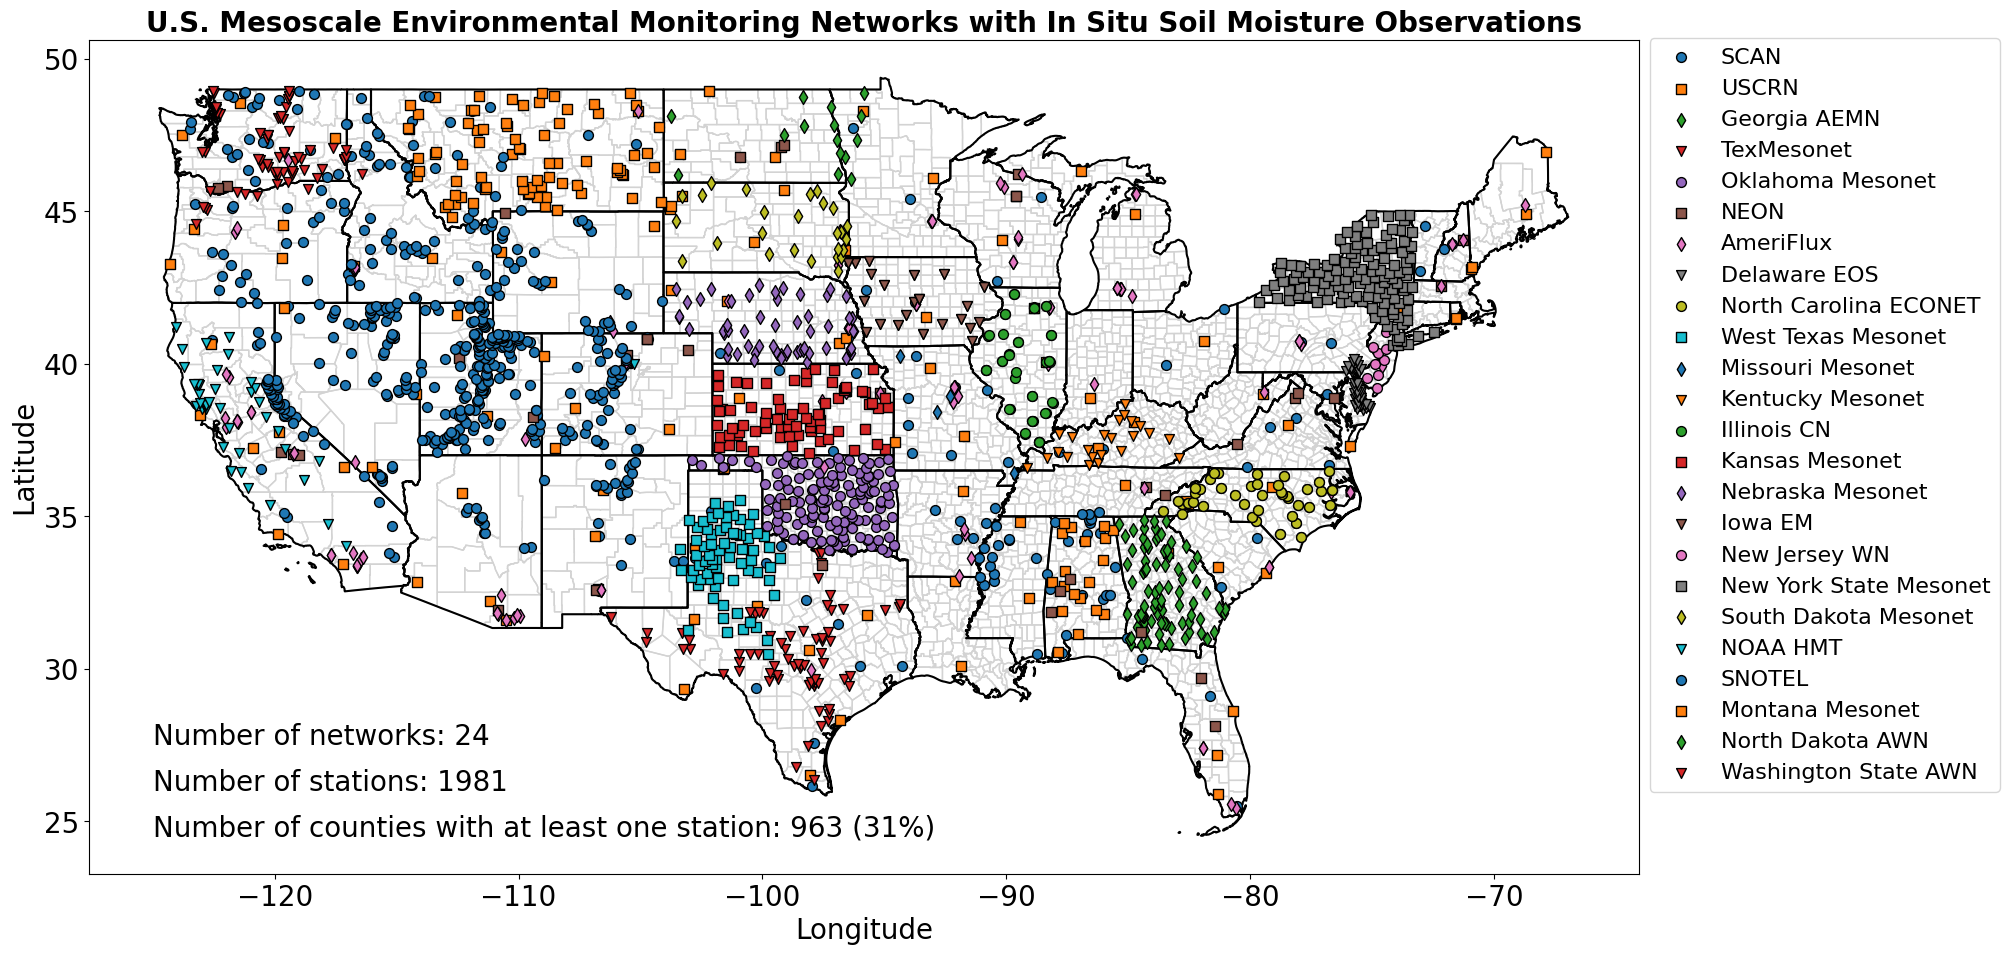

In [7]:
# Define colormap
cmap = plt.colormaps['Paired']

# Define markers (multiply by 10 to have more markers than networks)
markers = ['o','s','d','v'] * 10

# Create base map (counties)
base = counties.plot(color='none', edgecolor="lightgray",figsize=(20,20))

# Add state boundaries to base map
states.plot(ax=base, color="none", edgecolor="black", linewidth=1.5)

# Uncomment line below to add scale bar
# base.add_artist(ScaleBar(1)) 

# Add stations from each network using a loop to add 
# network-specific styling
for k, network in enumerate(stations['network'].unique()):
    idx = stations['network'] == network
    gdf_value = stations[idx]
    color = cmap(k/N_networks)
    gdf_value.plot(ax=base, marker=markers[k], label=network, markersize=50, alpha=1.0, edgecolor='k', aspect=1.25)
    
plt.title('U.S. Mesoscale Environmental Monitoring Networks with In Situ Soil Moisture Observations', size=20, fontweight='bold')
plt.xlabel('Longitude', size=20)
plt.ylabel('Latitude', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(-125, 27.5, f"Number of networks: {N_networks}", size=20)
plt.text(-125, 26, f"Number of stations: {stations.shape[0]}", size=20)
plt.text(-125, 24.5, f"Number of counties with at least one station: {N_counties} ({N_counties_perc}%)", size=20)
plt.legend(loc='best', ncol=1, fontsize=16, bbox_to_anchor=(1, 1.015))

# # Uncomment line below to place legend outside (and mute previous line)
# plt.legend(loc='lower left', ncol=5, fontsize=15, bbox_to_anchor=(0, -0.35))

# Uncomment line to save figure
# plt.savefig('us_map_soil_moisture_stations_2023.jpg', dpi=600, bbox_inches='tight')

plt.show()


## Practice

- Create separate maps for other U.S. territories and add them to the previous either as subplots or as inset maps.